# Import Library

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Level 1: Understanding the Terrain

## Load Dataset

In [4]:
# Membaca dataset
df = pd.read_csv("..\data\Odyssey 1  Data Set - Telco Data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Memilih fitur numerical dan categorical
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('SeniorCitizen', errors='ignore')
numerical_cols = numerical_cols.append(pd.Index(['TotalCharges']))  # Add 'SeniorCitizen'

categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('customerID', errors='ignore')  # Remove 'customerID'
categorical_cols = categorical_cols.drop('TotalCharges', errors='ignore')  # Remove 'customerID'
categorical_cols = categorical_cols.append(pd.Index(['SeniorCitizen']))  # Add 'SeniorCitizen'

In [6]:
# Mengubah tipe data 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
# Menentukan lebar plot untuk visualisasi
n_plots_numerical = len(numerical_cols)
n_rows_numerical = (n_plots_numerical // 3) + (n_plots_numerical % 3 > 0)  # Menentukan jumlah baris berdasarkan jumlah kolom numerik

n_plots_categorical = len(categorical_cols)
n_rows_categorical = (n_plots_categorical // 3) + (n_plots_categorical % 3 > 0)

## Quick EDA

In [8]:
# Melihat Struktur Dataset:
print("Shape of dataset:", df.shape)

Shape of dataset: (7043, 21)


- Terdapat 21 fitur dalam dataset.
- Terdapat 7043 data dalam datset yang tersedia.

In [9]:
# Melihat kolom-kolom dari data
print("\nColumns and data types:\n", df.dtypes)


Columns and data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


- Terdapat beberapa fitur yang tipe datanya tidak sesuai.
- SeniorCitizen harusnya fitur categorical.
- TotalCharges harusnya fitur numerical.

In [10]:
# Mengecek missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [11]:
# Mengecek jumlah data duplikat
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

Jumlah data duplikat: 0


- Tidak ada data yang duplikat dalam dataset.

In [12]:
# Mengecek data outlier dengan metode IQR
for col in numerical_cols:
	Q1 = df[col].quantile(0.25)
	Q3 = df[col].quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
	print(f"Jumlah Outliers Column {col}: {len(outliers)}")

Jumlah Outliers Column tenure: 0
Jumlah Outliers Column MonthlyCharges: 0
Jumlah Outliers Column TotalCharges: 0


- Tidak ada data outlier dalam dataset.

## Statistical Summaries

In [13]:
# Statistik deskriptif untuk fitur numerical
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Berdasarkan statistik deskriptif tersebut, dapat diambil beberapa insight yakni sebagai berikut.
- Tenure (Durasi Pelanggan Menjadi Langganan): Ada perbedaan signifikan antara pelanggan baru dan pelanggan yang sudah lama, yang dapat memengaruhi tingkat churn. Pelanggan baru mungkin lebih rentan terhadap churn.

- MonthlyCharges (Biaya Bulanan): Pelanggan dengan biaya lebih tinggi mungkin memiliki kebutuhan layanan yang lebih kompleks, tetapi mereka juga mungkin lebih sensitif terhadap harga, yang bisa meningkatkan risiko churn.

- TotalCharges (Total Biaya yang Dibayarkan): Pelanggan dengan TotalCharges rendah mungkin pelanggan baru atau pelanggan churn lebih cepat, sedangkan pelanggan dengan TotalCharges tinggi menunjukkan loyalitas.

In [14]:
# Statistik deskriptif untuk fitur categorical
df[categorical_cols].describe(include='O')

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


Berdasarkan statistik deskriptif tersebut, dapat diambil beberapa insight yakni sebagai berikut.
- Gender: Gender sepertinya tidak menjadi faktor utama dalam churn, tetapi analisis lebih lanjut diperlukan untuk konfirmasi.

- Partner & Dependents: Pelanggan tanpa pasangan dan tanggungan mungkin lebih fleksibel untuk membatalkan layanan, sehingga lebih rentan terhadap churn.

- PhoneService dan MultipleLines: Pelanggan dengan layanan multiple lines mungkin memiliki kebutuhan lebih kompleks, yang dapat memengaruhi loyalitas mereka.

- InternetService: Pelanggan dengan Fiber optic mungkin memiliki ekspektasi lebih tinggi terhadap layanan, sehingga bisa lebih sensitif terhadap masalah kualitas.

- Add-on Services (OnlineSecurity, OnlineBackup, dll): Kurangnya adopsi layanan tambahan dapat menunjukkan peluang upselling. Namun, pelanggan tanpa add-on mungkin lebih mudah churn karena kurangnya keterikatan.

- Contract: Kontrak jangka pendek adalah salah satu indikator utama churn, dan pelanggan dengan kontrak ini perlu lebih diperhatikan.

- PaperlessBilling: Paperless Billing dapat menjadi indikasi bahwa pelanggan lebih modern, tetapi mungkin juga lebih sensitif terhadap masalah pembayaran otomatis.

- PaymentMethod: Pelanggan dengan metode pembayaran manual seperti electronic check mungkin lebih rentan terhadap churn dibandingkan metode pembayaran otomatis seperti kartu kredit atau debit otomatis.

- Churn: Meskipun mayoritas pelanggan tetap setia, ada proporsi churn yang signifikan (~26,5%). Ini menunjukkan ada ruang untuk meningkatkan retensi pelanggan.

## Label (Churn) Distribution


Churn distribution:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_28292\3442109670.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette=['blue', 'red'])


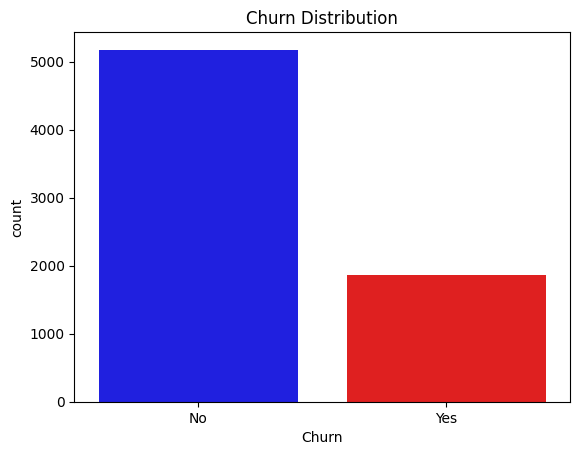

In [15]:
# Distribusi churn
print("\nChurn distribution:\n", df['Churn'].value_counts())
sns.countplot(data=df, x='Churn', palette=['blue', 'red'])
plt.title("Churn Distribution")
plt.show()

- Terdapat class imbalance pada label (churn) yang cukup besar.

## Univariate Analysis

### Numeric Variables

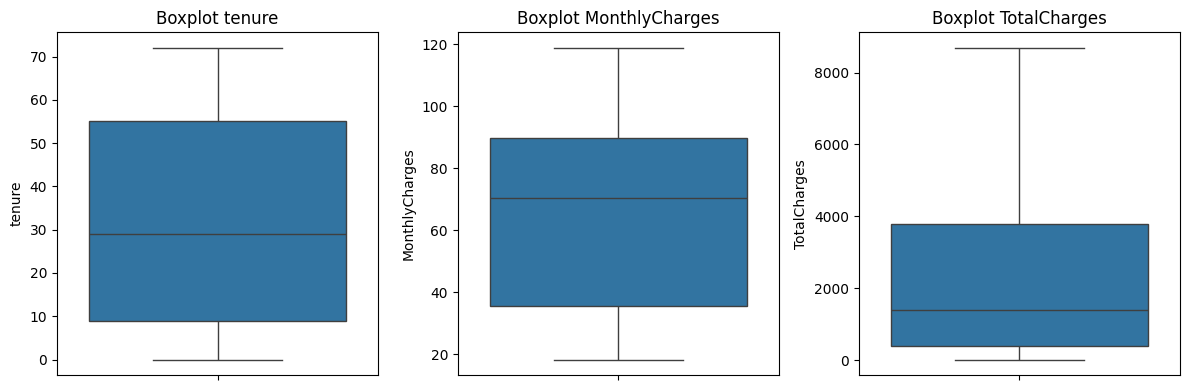

In [16]:
# Univariate Analysis for Numerical Variables
num_features = len(numerical_cols)
cols = 3
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(numerical_cols, 1):
	plt.subplot(rows, cols, i)
	sns.boxplot(y=column, data=df)
	plt.title(f'Boxplot {column}')
plt.tight_layout()
plt.show()

Berdasarkan grafik tersebut, dapat diambil beberapa insight yaitu sebagai berikut ini.
- Tenure: Pelanggan baru (tenure rendah) merupakan bagian signifikan dari dataset, sehingga program retensi untuk pelanggan baru bisa menjadi prioritas. Pelanggan dengan tenure lebih lama cenderung lebih loyal, sehingga mereka bisa difokuskan untuk upselling atau program loyalitas.

- MonthlyCharges: Pelanggan dengan MonthlyCharges lebih tinggi (di atas Q3) mungkin memiliki kebutuhan layanan lebih kompleks, sehingga strategi peningkatan nilai (value proposition) pada segmen ini sangat penting. Sedangkan pelanggan dengan biaya bulanan lebih rendah (di bawah Q1) mungkin lebih rentan terhadap churn karena mereka memiliki keterikatan layanan yang lebih rendah.

- TotalCharges: Pelanggan dengan TotalCharges rendah (di bawah Q1) kemungkinan besar adalah pelanggan baru atau pelanggan churn lebih cepat. Sedangkan pelanggan dengan TotalCharges tinggi (di atas Q3) merupakan pelanggan loyal yang dapat menjadi target untuk program upselling.


### Categorical Variables

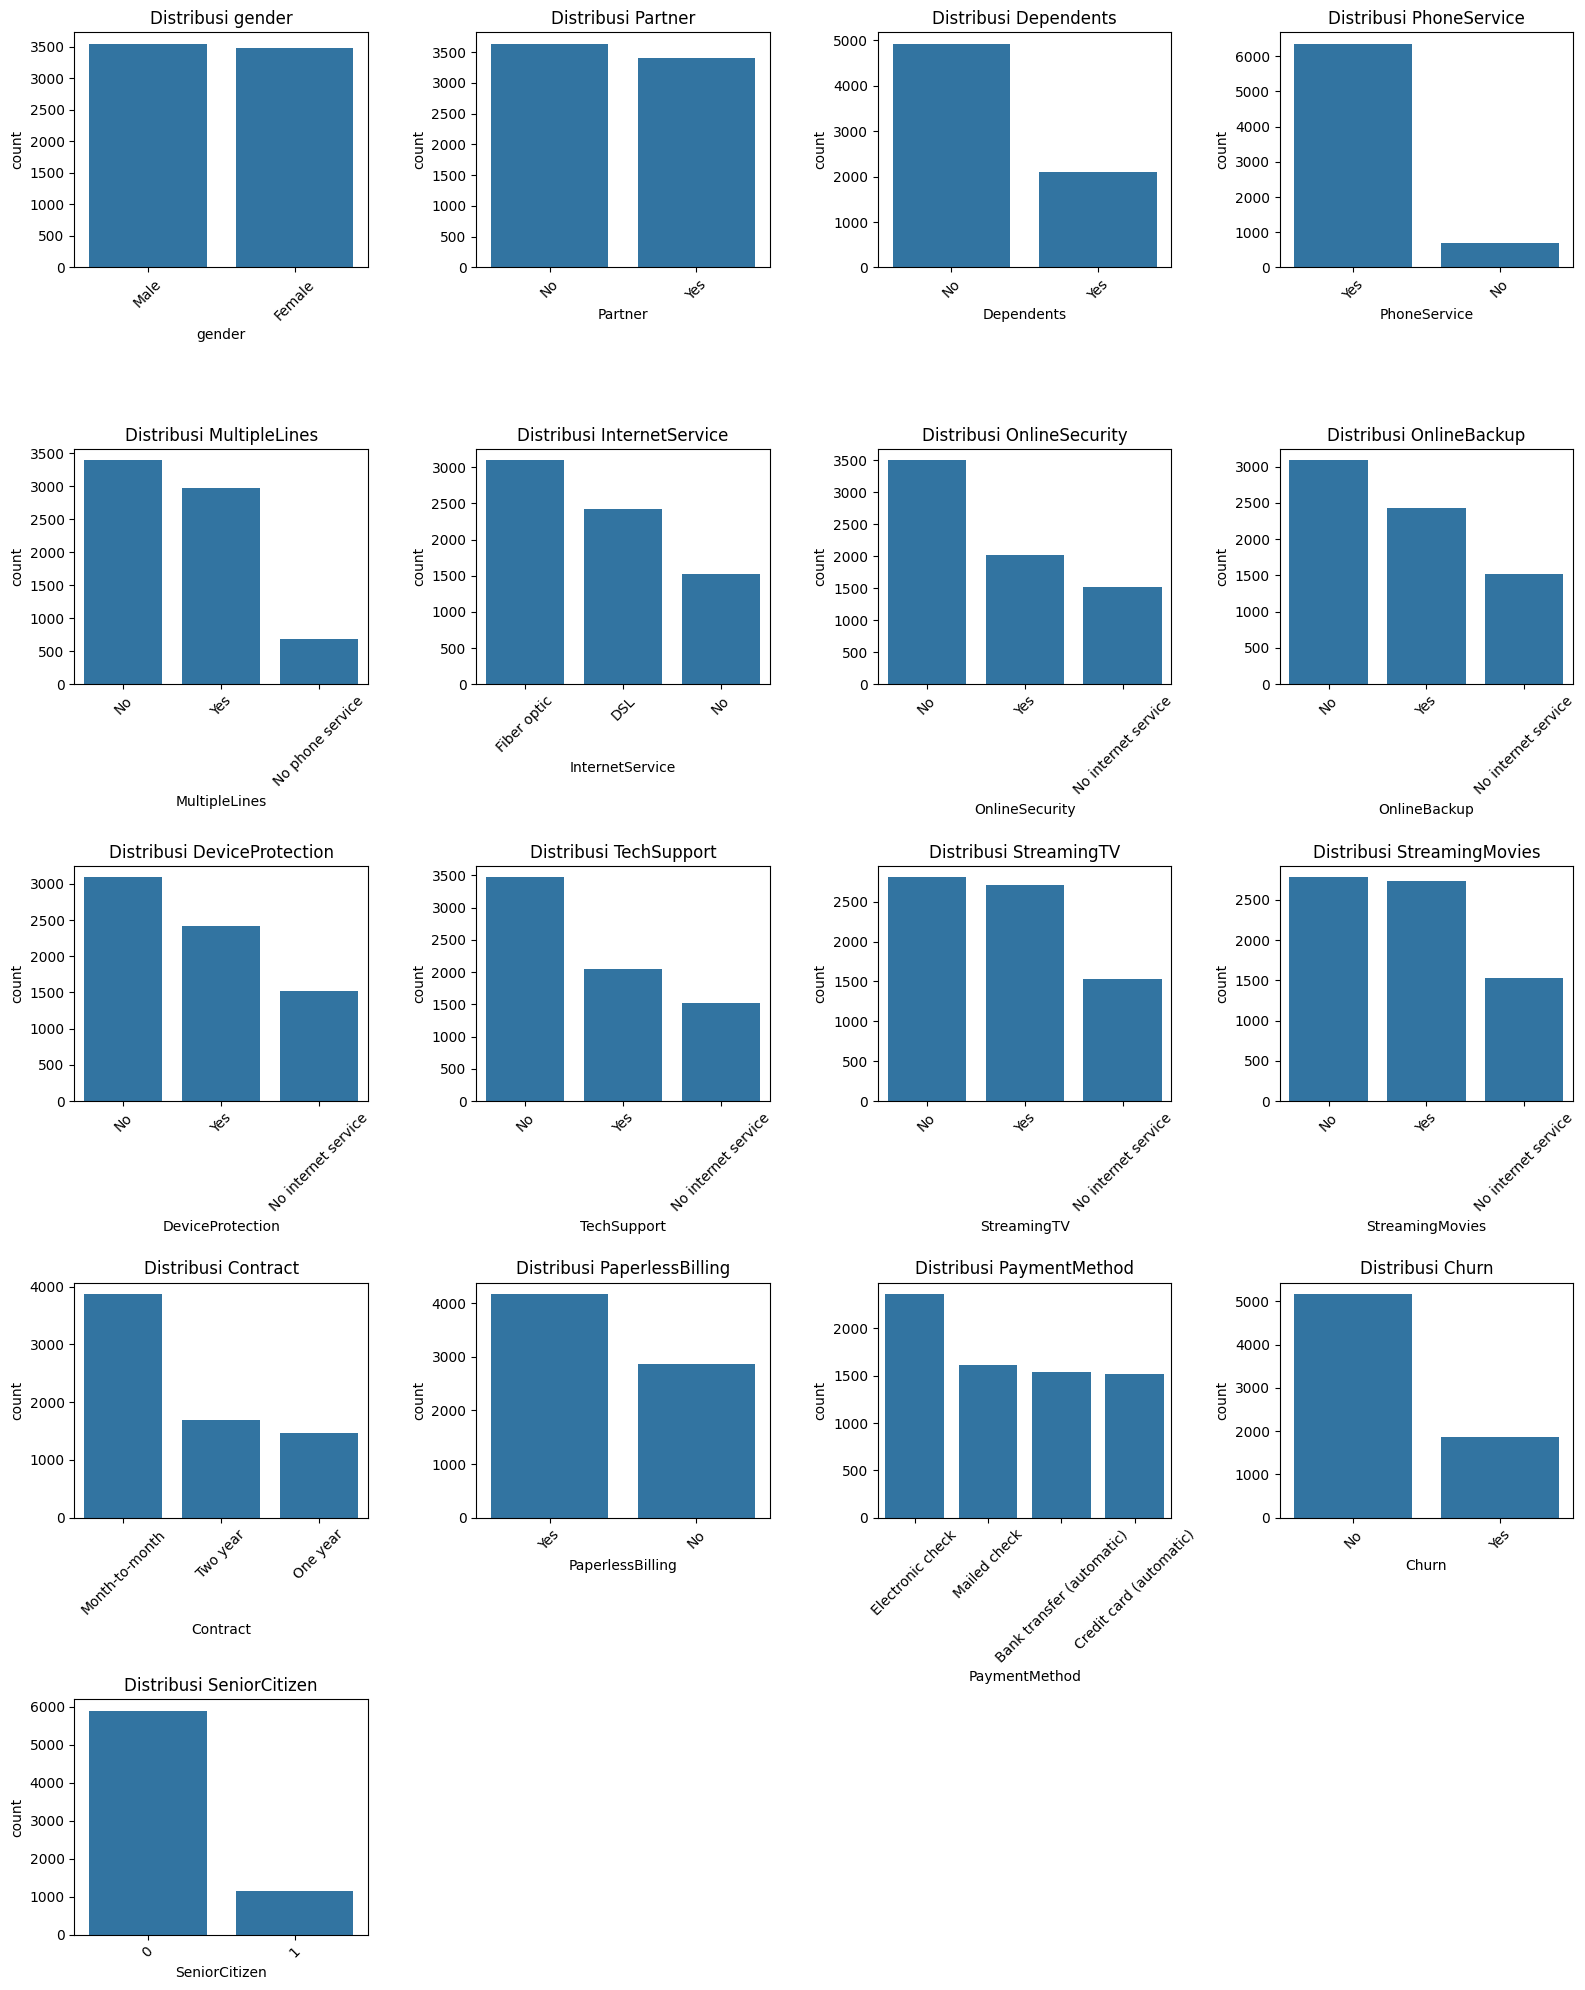

In [17]:
# Univariate Analysis for Categorical Variables
num_features = len(categorical_cols)
cols = 4
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(categorical_cols, 1):
	plt.subplot(rows, cols, i)
	sns.countplot(x=df[column], order=df[column].value_counts().index)
	plt.title(f'Distribusi {column}')
	plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Berdasarkan grafik tersebut, berikut merupakan insight-insight yang dapat diambil.
- Gender: Distribusi gender seimbang antara pria dan wanita. Tidak ada bias gender dalam dataset, sehingga gender mungkin tidak menjadi faktor utama yang memengaruhi analisis churn.

- Partner & Dependents: Pelanggan tanpa pasangan atau tanggungan kemungkinan besar adalah individu lajang, yang bisa lebih rentan churn karena kebutuhan layanan mereka lebih fleksibel.

- PhoneService & MultipleLines: Hampir semua pelanggan menggunakan layanan telepon. Selain itu, sebagian besar pelanggan menggunakan layanan telepon tunggal (MultipleLines: No), sementara sebagian kecil menggunakan MultipleLines. Perusahaan dapat menyediakan bundling layanan tambahan untuk pelanggan MultipleLines dapat meningkatkan nilai penjualan.

- InternetService: Fiber optic mendominasi, tetapi pelanggan ini mungkin lebih rentan churn karena biaya layanan yang lebih tinggi dibandingkan DSL.

- OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport: Layanan tambahan seperti OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport lebih banyak tidak digunakan oleh pelanggan. Pelanggan mungkin kurang teredukasi tentang manfaat layanan ini, sehingga program edukasi atau promosi dapat meningkatkan adopsi layanan tambahan.

- StreamingTV & StreamingMovies: Sebagian besar pelanggan menggunakan layanan StreamingTV dan StreamingMovies, tetapi proporsi yang tidak menggunakan layanan ini juga cukup besar. Pelanggan yang menggunakan layanan streaming bisa menjadi fokus untuk peningkatan layanan atau penawaran eksklusif.

- Contract: Mayoritas pelanggan berada pada kontrak Month-to-month, sementara kontrak Two year memiliki proporsi paling kecil. Pelanggan Month-to-month lebih rentan churn dibandingkan kontrak jangka panjang, sehingga strategi untuk mengonversi pelanggan ini ke kontrak jangka panjang dapat membantu mengurangi churn.

- PaperlessBilling & PaymentMethod: Sebagian besar pelanggan menggunakan metode penagihan tanpa kertas (PaperlessBilling: Yes). Selain itu, pembayaran elektronik (Electronic check) adalah metode pembayaran paling dominan. Pelanggan PaperlessBilling dengan Electronic check mungkin mencari kenyamanan, tetapi bisa lebih mudah churn karena metode ini kurang melibatkan pelanggan dibandingkan metode otomatis seperti kartu kredit.

- SeniorCitizen: Sebagian besar pelanggan bukan SeniorCitizen (pelanggan lansia). Lansia mungkin memiliki kebutuhan layanan berbeda, sehingga pendekatan yang dipersonalisasi untuk kelompok ini bisa efektif.

- Churn: Sebagian besar pelanggan tetap bertahan (Churn: No), tetapi ada jumlah signifikan yang churn. Fokus pada faktor-faktor yang menyebabkan churn bisa menjadi prioritas untuk mempertahankan pelanggan.






## Multivariate Analysis

### Correlation Matrix

In [18]:
df[numerical_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.00000,0.247900,0.825880
MonthlyCharges,0.24790,1.000000,0.651065
TotalCharges,0.82588,0.651065,1.000000


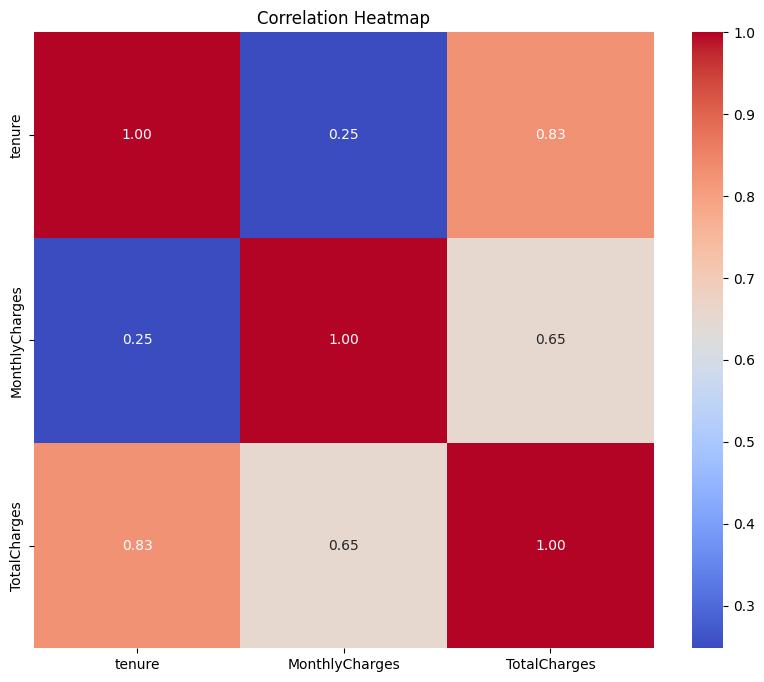

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Level 2: Finding the Drivers of Churn

In [20]:
target_col = 'Churn'
categorical_cols = categorical_cols.drop(target_col, errors='ignore')  # Remove 'customerID'

## Feature Importance for Numerical Columns

> Feature numerical tenure (durasi berlangganan) memiliki pengaruh paling signifikan terhadap churn dengan korelasi negatif.

In [21]:
# Korelasi antara churn dengan kolom numerik
print("Korelasi antara churn dengan kolom numerik lainnya:")
df[target_col] = df[target_col].apply(lambda x: 1 if x == 'Yes' else 0)  # Encode churn ke 1/0

correlation = df[numerical_cols].corrwith(df[target_col])
print(correlation)

Korelasi antara churn dengan kolom numerik lainnya:
tenure           -0.352229
MonthlyCharges    0.193356
TotalCharges     -0.199484
dtype: float64


Berdasarkan hasil feature importance tersebut, berikut insight-insight yang didapatkan.

- Tenure (Durasi Berlangganan) memiliki pengaruh paling signifikan terhadap churn dengan korelasi negatif. Artinya, semakin lama pelanggan berlangganan, semakin kecil kemungkinan mereka untuk churn. Pelanggan baru atau dengan durasi langganan pendek memiliki risiko churn yang lebih tinggi.

- MonthlyCharges (Biaya Bulanan) menunjukkan korelasi positif dengan churn, meskipun pengaruhnya lebih kecil. Pelanggan dengan biaya bulanan lebih tinggi memiliki sedikit risiko churn yang lebih besar, kemungkinan karena persepsi bahwa biaya terlalu mahal dibandingkan dengan manfaat.

- TotalCharges (Total Pembayaran Keseluruhan) menunjukkan korelasi negatif, meskipun tidak sekuat tenure. Ini menunjukkan bahwa pelanggan dengan akumulasi pembayaran yang tinggi (biasanya pelanggan dengan durasi langganan panjang) cenderung lebih loyal dan lebih kecil kemungkinan untuk churn.

In [22]:
# # Visualisasi korelasi churn dengan kolom numerik
# plt.figure(figsize=(16, 8))
# for i, col in enumerate(numerical_cols, 1):
#     plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
#     sns.histplot(df[col], kde=True, color='#019fab')
#     plt.title(f"{col} vs {target_col}")
# plt.tight_layout()
# plt.show()

In [23]:
# # Visualisasi korelasi churn dengan kolom numerik
# plt.figure(figsize=(16, 8))
# for i, col in enumerate(numerical_cols, 1):
#     plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
#     sns.scatterplot(data=df, x=col, y=target_col, palette=['blue', 'red'])
#     plt.title(f"{col} vs {target_col}")
# plt.tight_layout()
# plt.show()

## Analysis of Categorical Columns


Analisis kolom kategorikal:


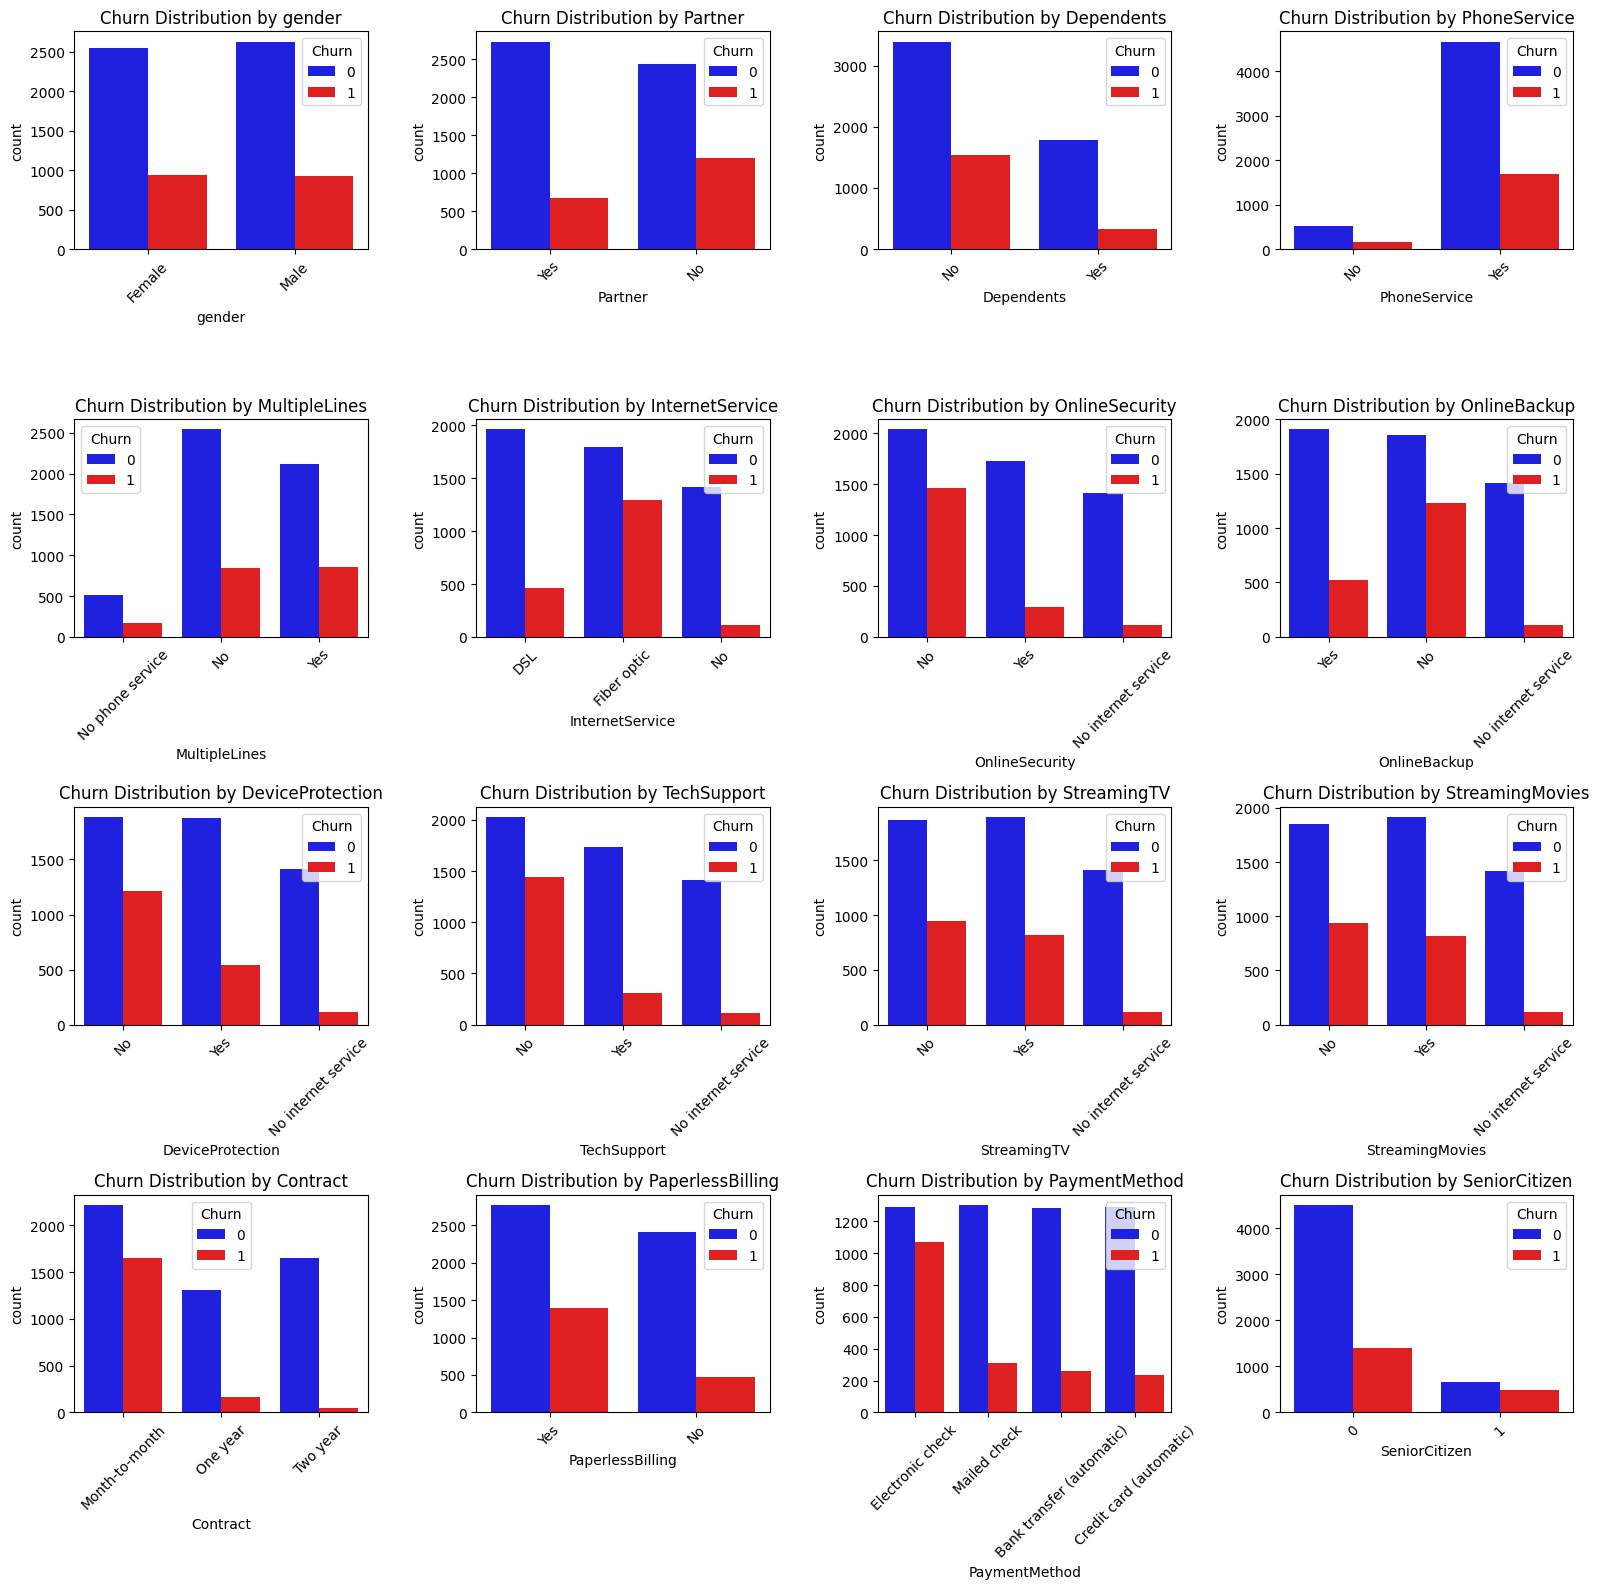

In [24]:
# Distribusi feature categorical untuk setiap churn
print("\nAnalisis kolom kategorikal:")
num_features = len(categorical_cols)
cols = 4
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(categorical_cols, 1):
	plt.subplot(rows, cols, i)
	sns.countplot(data=df, x=column, hue='Churn', palette=['blue', 'red'])
	plt.title(f"Churn Distribution by {column}")
	plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Chi-Square Test

> Feature Contract adalah faktor yang paling signifikan terhadap churn.

In [25]:
# Chi-Square Test untuk kolom kategorikal
print("\nChi-Square Test Results:")
feature_correlation_churn = []
for col in categorical_cols:
	if col != target_col:
		contingency_table = pd.crosstab(df[col], df[target_col])
		chi2, p, dof, expected = chi2_contingency(contingency_table)
		print(f"- {col}: Chi2 = {chi2:.2f}, p-value = {p:.5f}", end=' => ')
		if p < 0.05:
			feature_correlation_churn.append(col)
			print(f"{col} memiliki hubungan signifikan dengan churn.")
		else:
			print(f"{col} tidak memiliki hubungan signifikan dengan churn.")


Chi-Square Test Results:
- gender: Chi2 = 0.48, p-value = 0.48658 => gender tidak memiliki hubungan signifikan dengan churn.
- Partner: Chi2 = 158.73, p-value = 0.00000 => Partner memiliki hubungan signifikan dengan churn.
- Dependents: Chi2 = 189.13, p-value = 0.00000 => Dependents memiliki hubungan signifikan dengan churn.
- PhoneService: Chi2 = 0.92, p-value = 0.33878 => PhoneService tidak memiliki hubungan signifikan dengan churn.
- MultipleLines: Chi2 = 11.33, p-value = 0.00346 => MultipleLines memiliki hubungan signifikan dengan churn.
- InternetService: Chi2 = 732.31, p-value = 0.00000 => InternetService memiliki hubungan signifikan dengan churn.
- OnlineSecurity: Chi2 = 850.00, p-value = 0.00000 => OnlineSecurity memiliki hubungan signifikan dengan churn.
- OnlineBackup: Chi2 = 601.81, p-value = 0.00000 => OnlineBackup memiliki hubungan signifikan dengan churn.
- DeviceProtection: Chi2 = 558.42, p-value = 0.00000 => DeviceProtection memiliki hubungan signifikan dengan churn.
-

In [26]:
# Hasil Chi-square test
print(f'Feature yang memiliki hubungan signifikan dengan churn :', end=' ')
for i, col in enumerate(feature_correlation_churn, start=1):
	if i == len(feature_correlation_churn):
		print(f'{col}.')
	else:

	 	print(f'{col}', end=', ')

Feature yang memiliki hubungan signifikan dengan churn : Partner, Dependents, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, SeniorCitizen.


Berdasarkan hasil Chi-square test tersebut, dapat diambil beberapa insight yakni sebagai berikut.

- Contract adalah faktor yang paling signifikan, menunjukkan bahwa pelanggan dengan kontrak bulanan memiliki risiko churn yang jauh lebih tinggi dibandingkan pelanggan dengan kontrak tahunan atau dua tahunan.

- Feature PaymentMethod juga penting, dengan metode pembayaran otomatis seperti auto-pay menunjukkan loyalitas yang lebih tinggi.

- Banyak feature categorical yang memiliki hubungan signifikan dengan churn, terutama kolom yang berhubungan dengan jenis layanan yang digunakan (seperti InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) dan pengaturan kontrak (seperti Contract dan PaymentMethod).

- Feature seperti Partner dan Dependents menunjukkan bahwa pelanggan dengan pasangan atau tanggungan cenderung lebih loyal dibandingkan yang tidak memiliki.

- Feature Gender dan PhoneService tidak memiliki hubungan signifikan dengan churn. Artinya, jenis kelamin pelanggan dan keberadaan layanan telepon tidak berdampak besar terhadap risiko churn.


# Level 3: Building a Predictive Model

## Data Preparation

## Modeling

## Evaluation

## Feature Importance

# Archive

## Crosstab Churn

In [27]:
# # Distribusi kategori setiap churn
# num_features = len(categorical_cols)
# cols = 4
# rows = math.ceil(num_features / cols)
# plt.figure(figsize=(cols * 4, rows * 4))
# for i, column in enumerate(categorical_cols, 1):
#     plt.subplot(rows, cols, i)
#     sns.countplot(data=df, x=column, hue='Churn', palette=['blue', 'red'])
#     plt.title(f"Churn Distribution by {column}")
#     plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [28]:
# # Crosstab churn dengan variabel kategorikal
# for col in categorical_cols:
#     if col != 'Churn':
#         crosstab = pd.crosstab(df[col], df['Churn'], normalize='index')
#         print(f"Crosstab for {col} vs Churn:")
#         print(crosstab)
#         crosstab.plot(kind='bar', stacked=True)
#         plt.title(f"{col} vs Churn")
#         plt.xlabel(col)
#         plt.ylabel('Proportion')
#         plt.show()

In [29]:
# # Distribusi kategori
# categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaymentMethod']
# for col in categorical_columns:
#     print(f"\nValue counts for {col}:\n", df[col].value_counts())
#     sns.countplot(data=df, x=col, hue='Churn', palette=['blue', 'red'])
#     plt.title(f"Churn Distribution by {col}")
#     plt.xticks(rotation=45)
#     plt.show()